# Лабораторная работа №2

### Выполнила: Чистякова Юлия

### Группа: 15-АС

### 30 вариант (Occupancy)

## Цель работы - получение навыков работы с методами классификации.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt

from scipy import interp
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)

df = pd.read_csv('datatraining.txt')
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


## 1.Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных

 ##### Date - время:год, день, месяц, час,минута,секунда
 ##### Temperature - температура в цельсиях
 ##### Humidity - относительная влажность в %
 ##### Light - освещение в люксах
 ##### CO2 - уровень углекислого газа в ppm
 ##### HumidityRatio - влажность
 ##### Occupancy - занятость (0- не занят, 1- занят)

## 2.Удалите дубликаты строк в наборе данных

In [3]:
df.shape

(8143, 7)

In [4]:
df = df.drop_duplicates()
df = df.dropna()
df = df.reset_index(drop=True)
df.shape

(8143, 7)

## 3.Оцените сбалансированность данных по классам. Используйте полученную информацию при выборе метрики оценки качества классификации

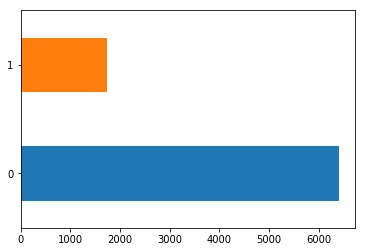

In [5]:
df['Occupancy'].value_counts().plot.barh()
plt.show()

### По графику видно, что данные не сбалансированны. Используем ROC кривую для оценки качества работы алгоритма

## 4. Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования.

## BoxPlot для признаков до масштабирования

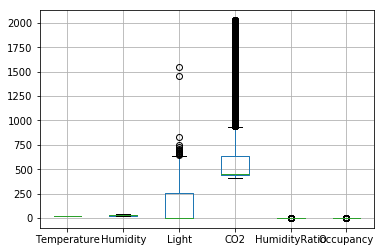

In [6]:
df.boxplot()
plt.show()

In [7]:
numerical_columns = [i for i in df.columns[1:6] if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns[1:6] if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
categorial:  []


### Не стали учитывать колонки Дата и Занятость т. к. дата не участвует в нашей выборке а Занятость является классом и ее нельзя масштабировать

### Произведем нормализацию числовых признаков

In [8]:
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,1.000000,0.470533,0.275490,0.190933,0.557318,1
1,2015-02-04 17:51:59,0.992823,0.470332,0.277754,0.186446,0.554807,1
2,2015-02-04 17:53:00,0.992823,0.469326,0.275490,0.186136,0.553761,1
3,2015-02-04 17:54:00,0.992823,0.467315,0.275490,0.182887,0.551669,1
4,2015-02-04 17:55:00,0.980861,0.467315,0.275490,0.180566,0.547851,1


## BoxPlot для признаков после масштабирования

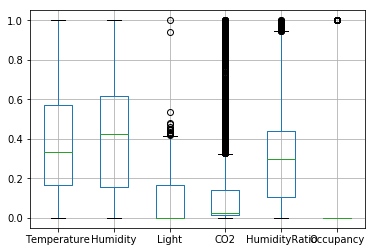

In [9]:
df.boxplot()
plt.show()

# 5. Выполните замену категориальных признаков; выберите и обоснуйте способ замены.

### Замена категориальных признаков не нужна т.к. эти признаки отсутствуют в нашей базе данных

# 6.	Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации)

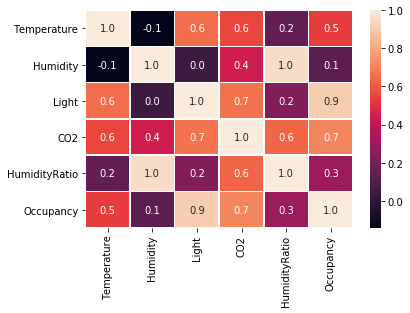

,Temperature,Humidity,Light,CO2,HumidityRatio
Temperature,1.000000,-0.141759,0.649942,0.559894,0.151762
Humidity,-0.141759,1.000000,0.037828,0.439023,0.955198
Light,0.649942,0.037828,1.000000,0.664022,0.230420
CO2,0.559894,0.439023,0.664022,1.000000,0.626556
HumidityRatio,0.151762,0.955198,0.230420,0.626556,1.000000


In [54]:
corr = df.drop('Occupancy', axis=1).corr()
sns.heatmap(df.corr(), annot=True, fmt='.1f', linewidths=.5)
plt.show()
corr

# 7. Заполните пропущенные значения в данных

In [12]:
df.count()

date             8143
Temperature      8143
Humidity         8143
Light            8143
CO2              8143
HumidityRatio    8143
Occupancy        8143
dtype: int64

In [13]:
df.shape

(8143, 7)

### Пропущенных данных нет

# 8.	Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию. 

In [14]:
df_test = pd.read_csv('datatest.txt')
df_test.head()


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


### Загрузили тестовые данные. Теперь выполняем нормализацию и проверяем на пропущенность данных

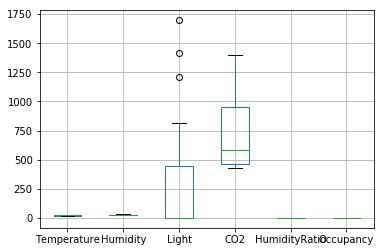

In [15]:
df_test.boxplot()
plt.show()

In [16]:
numerical_columns = [i for i in df.columns[1:6] if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns[1:6] if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)
scaler = MinMaxScaler()
df_test[numerical_columns] = scaler.fit_transform(df_test[numerical_columns])
df_test.head()

numerical:  ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
categorial:  []


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,0.831683,0.445132,0.344793,0.330033,0.704212,1
141,2015-02-02 14:19:59,0.835960,0.447053,0.340787,0.341523,0.708308,1
142,2015-02-02 14:21:00,0.838812,0.440651,0.337409,0.351030,0.704689,1
143,2015-02-02 14:22:00,0.837030,0.429448,0.290912,0.356245,0.694383,1
144,2015-02-02 14:23:00,0.844515,0.437450,0.287877,0.360605,0.705384,1


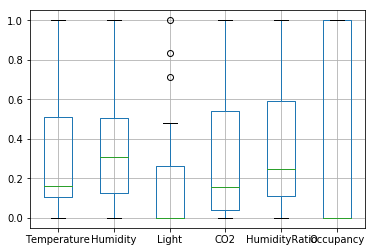

In [17]:
df_test.boxplot()
plt.show()

In [18]:
df_test.shape

(2665, 7)

In [19]:
df_test.count()

date             2665
Temperature      2665
Humidity         2665
Light            2665
CO2              2665
HumidityRatio    2665
Occupancy        2665
dtype: int64

### Разделим данные для обучения и теста 

In [20]:
x_train, y_train = df[numerical_columns + ['Occupancy']].drop('Occupancy', axis=1), df['Occupancy']
x_test, y_test = df_test[numerical_columns + ['Occupancy']].drop('Occupancy', axis=1), df_test['Occupancy']

### Реализуем линейный классификатор ( персептрон)

In [21]:
from sklearn.linear_model import Perceptron
slf = Perceptron()
#найдем оптимальные параметры для классификатора
#alfa - Константа, которая умножает член регуляризации
#max_iter - Максимальное количество проходов над данными обучения (иначе говоря, эпохи)
paramsearch = GridSearchCV(estimator=slf, param_grid=dict(alpha=np.linspace(0,1,20)[1:],max_iter=[x for x in range(1,50)]), n_jobs=-1)
paramsearch.fit(x_train, y_train)
best_score = paramsearch.best_score_
selected_alpha = paramsearch.best_estimator_.alpha
selected_max_iter = paramsearch.best_estimator_.max_iter
print('best score:',best_score,'| alpha:',selected_alpha, '| max_iter:', selected_max_iter)

#создаем модель персептрона по нашим оптимальным данным
perceptron = sk.linear_model.Perceptron(alpha=selected_alpha,max_iter=selected_max_iter)
#тренируем ее
perceptron.fit(x_train, y_train)
#смотрим в каком проценте случаев классификатор дает верный результат
test_score  = np.mean(y_test == perceptron.predict(x_test))
print('test score: ', test_score)

best score: 0.9794915878668795 | alpha: 0.0526315789474 | max_iter: 5
test score:  0.972232645403


### Реализуем решающее дерево

In [22]:
#найдем оптимальные глубину и количества учитываемых параметров для классификатора решающее дерево
dtc = DecisionTreeClassifier()

params = {'max_depth': list(range(1,5)), 'max_features': list(range(1,5))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(x_train, y_train)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(x_train, y_train)
best_score  = np.mean(y_test == dtc.predict(x_test))
print('test score: ', best_score)
dtc.predict(x_test)

best train score: 0.9761758565639199 	 at features number: 4 	 at depth: 1
test score:  0.976735459662


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

Для построения ROC и PR кривых необходимо получить вероятности принадлежности примера к одному из классов, а затем варьировать границу выбора класса. Вероятности можно получить с помощью метода predict_proba

In [26]:
#Откалибруем линейный классификатор
#cv - кратность перекрестной проверки
#method - метод калибровки, так как у нас записей больше 1000 то рекомендуется использовать isotonic
#         если же данных << 1000 то sigmoid
clf_isotonic = CalibratedClassifierCV(perceptron, cv=10, method='isotonic')
clf_isotonic.fit(x_train, y_train)
probas_slf = clf_isotonic.predict_proba(x_test)

# Кривые PR

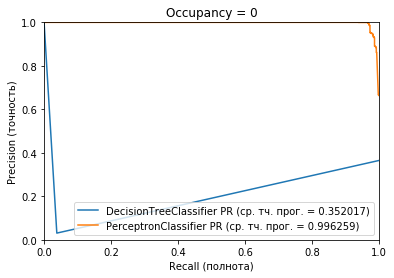

In [43]:
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test, probas_dtc0[:,0])
aps_dtc0 = average_precision_score(y_test,probas_dtc0[:,0])
plt.plot(recall, precision, label='DecisionTreeClassifier PR (ср. тч. прог. = %f)' % (aps_dtc0))

# Персептрон
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_slf[:,0])
aps_ptron0 = average_precision_score(y_test_invers,probas_slf[:,0])
plt.plot(recall, precision, label='PerceptronClassifier PR (ср. тч. прог. = %f)' % (aps_ptron0))

# вывод графика
plt.xlabel('Recall (полнота)')
plt.ylabel('Precision (точность)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('Occupancy = 0')
plt.show()

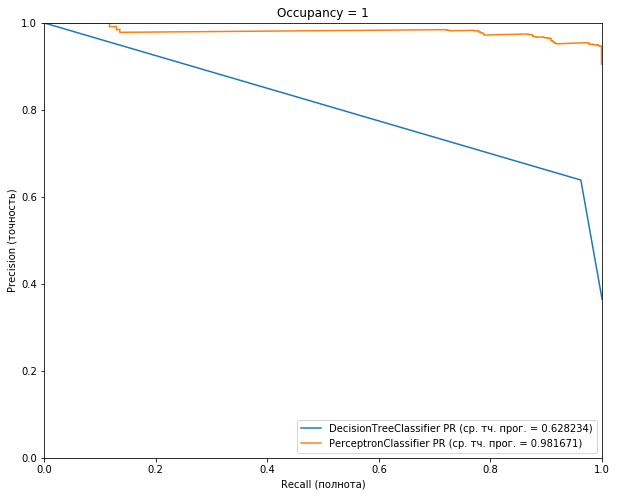

In [48]:
plt.figure(figsize=(10,8))

# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test, probas_dtc0[:,1])
aps_dtc1 = average_precision_score(y_test,probas_dtc0[:,1])
plt.plot(recall, precision, label='DecisionTreeClassifier PR (ср. тч. прог. = %f)' % (aps_dtc1))

# Персептрон
precision, recall, thresholds = precision_recall_curve(y_test, probas_slf[:,1])
aps_ptron1 = average_precision_score(y_test,probas_slf[:,1])
plt.plot(recall, precision, label='PerceptronClassifier PR (ср. тч. прог. = %f)' % (aps_ptron1))

# вывод графика
plt.xlabel('Recall (полнота)')
plt.ylabel('Precision (точность)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('Occupancy = 1')
plt.show()

# Графики ROC

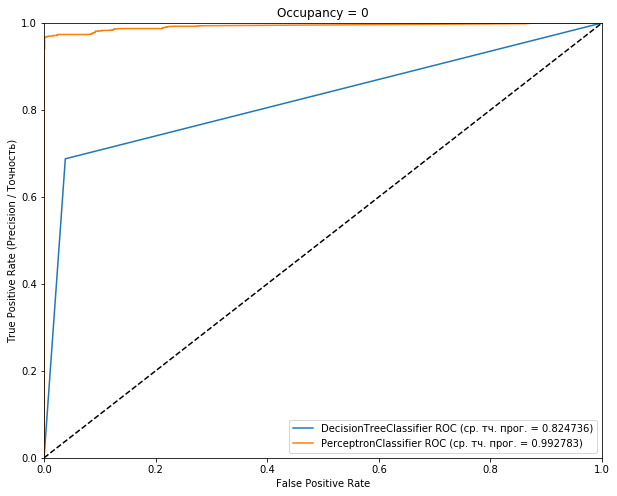

In [49]:
#кривая ошибок
#FPR false positive rate называется специфичностью алгоритма классификации
#TPR  true positive rate называется чувствительностью алгоритма классификации
plt.figure(figsize=(10,8))

# решающее дерево
tpr, fpr, thresholds = roc_curve(y_test, probas_dtc0[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='DecisionTreeClassifier ROC (ср. тч. прог. = %f)' % (roc_auc))   
    
# Персептрон
tpr, fpr, thresholds = roc_curve(y_test, probas_slf[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='PerceptronClassifier ROC (ср. тч. прог. = %f)' % (roc_auc))   

# вывод графика
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Precision / Точность)')
plt.legend(loc=4, fontsize='medium')
plt.title('Occupancy = 0')
plt.show()

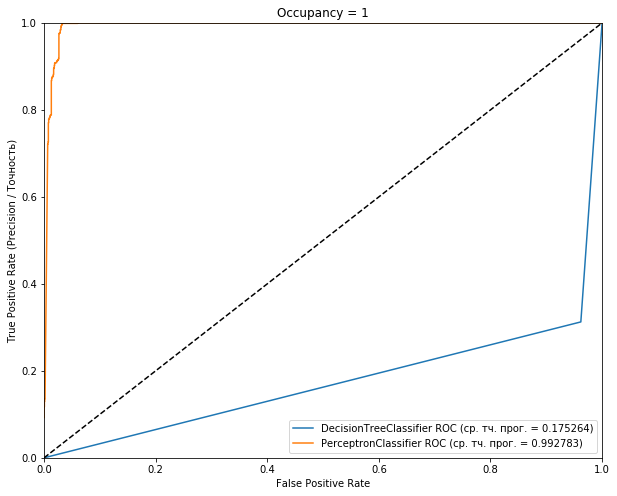

In [52]:
plt.figure(figsize=(10,8))

# решающее дерево
tpr, fpr, thresholds = roc_curve(y_test, probas_dtc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='DecisionTreeClassifier ROC (ср. тч. прог. = %f)' % (roc_auc)) 

# Персептрон
fpr, tpr, thresholds = roc_curve(y_test, probas_slf[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='PerceptronClassifier ROC (ср. тч. прог. = %f)' % (roc_auc))

# вывод графика
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Precision / Точность)')
plt.legend(loc=4, fontsize='medium')
plt.title('Occupancy = 1')
plt.show()


# Сравните кривые для классификаторов, указанных в задании, сделайте выводы

Классификаторы дерево принятия решений и линейный классификатор ( персептрон) имеют разные показатели качества относительно PR и ROC кривых. Данные классификаторы хорошо справляются со своей задачей, так как их точность ≈0.99. Задача классификации была решена